# Classifiez automatiquement des biens de consommation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
import string
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("./datas/list_products.csv")
df

uniq_id            crawl_timestamp   
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  \
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url   
0     http://www.flipkart.com/elegance-polyester-mul...  \
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name   
0     Elegance Polyester Multicolor Abstract Eyelet ...  \
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid   
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z  \
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image   
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [3]:
df.uniq_id.duplicated().sum()

0

## Utilisation de la librairie NLTK

In [4]:
nltk.download('punkt')

test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dar55\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokens  = tokenizer.tokenize(test.lower())

list(nltk.bigrams(tokens))

[('bonjour', 'je'),
 ('je', 'suis'),
 ('suis', 'un'),
 ('un', 'texte'),
 ('texte', 'd'),
 ('d', 'exemple'),
 ('exemple', 'pour'),
 ('pour', 'le'),
 ('le', 'cours'),
 ('cours', 'd'),
 ('d', 'openclassrooms'),
 ('openclassrooms', 'soyez'),
 ('soyez', 'attentifs'),
 ('attentifs', 'à'),
 ('à', 'ce'),
 ('ce', 'cours')]

In [6]:
for i in range(df.shape[0]):
    print(tokenizer.tokenize(str(df.product_name[i].lower())) + tokenizer.tokenize (str(df.description[i].lower())))

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'this', 'curtain', 'is', 'made', 'from', '100', 'high', 'quality', 'polyester', 'fabric', 'it', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'this', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'these', 'contemporary', 'eyelet', 'and', 'valance

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dar55\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dar55\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Suppression des stop words / lemmatisation / clean du texte

In [8]:
def clean_tokens():
    cleaned = []
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for i in range(df.shape[0]):
        text = str(df.product_name[i].lower()) + str(df.description[i].lower())
        text = text.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('_', ' ')
        text = re.sub(r'(.)\1{2,}', ' ', text)
        word_tokens = tokenizer.tokenize(text)
        cleaned += [[lemmatizer.lemmatize(w) for w in word_tokens if not w.isdigit() and w not in string.punctuation and w not in stop_words and w in re.findall(r'[a-z]{3,}', w) and w in re.findall(r'\D*', w)]]
        
    return cleaned
    
cleaned_tokens = clean_tokens()
cleaned_tokens_list = [' '.join(lst) for lst in cleaned_tokens]

cleaned_tokens_list

['elegance polyester multicolor abstract eyelet door curtainkey feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interior curtain made high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model color multicol

In [9]:
def clean_tokens_dl():
    cleaned_dl = []

    for i in range(df.shape[0]):
        text = str(df.product_name[i].lower()) + str(df.description[i].lower())
        text = text.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('_', ' ')
        text = re.sub(r'(.)\1{2,}', ' ', text)
        word_tokens = tokenizer.tokenize(text)
        cleaned_dl += [[w for w in word_tokens if not w.isdigit() and w not in string.punctuation and w in re.findall(r'[a-z]{3,}', w) and w in re.findall(r'\D*', w)]]
        
    return cleaned_dl
    
cleaned_tokens_dl = clean_tokens_dl()
cleaned_tokens_dl_list = [' '.join(lst) for lst in cleaned_tokens_dl]

cleaned_tokens_dl_list

['elegance polyester multicolor abstract eyelet door curtainkey feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interior curtain made high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model color multicol

## Creation des BOWs

### Avec bigrams

In [10]:
vectorizer = CountVectorizer(strip_accents= 'unicode', max_df=0.95, ngram_range=(1,2))
X = vectorizer.fit_transform(cleaned_tokens_list)
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())


vectorizer2 = TfidfVectorizer(strip_accents= 'unicode', max_df=0.95, ngram_range=(1,2))
X2 = vectorizer2.fit_transform(cleaned_tokens_list)
df_bow_sklearn2 = pd.DataFrame(X2.toarray(),columns=vectorizer2.get_feature_names_out())
df_bow_sklearn

aapno  aapno rajasthan  aari  aari embroidered  aari embroidery  aarika   
0         0                0     0                 0                0       0  \
1         0                0     0                 0                0       0   
2         0                0     0                 0                0       0   
3         0                0     0                 0                0       0   
4         0                0     0                 0                0       0   
...     ...              ...   ...               ...              ...     ...   
1045      0                0     0                 0                0       0   
1046      0                0     0                 0                0       0   
1047      0                0     0                 0                0       0   
1048      0                0     0                 0                0       0   
1049      0                0     0                 0                0       0   

      aarika self  ability  ability aid  ability lightweight  ...   
0               0        0            0                    0  ...  \
1               0        0            0                    0  ...   
2               0        0            0                    0  ...   
3               0        0            0                    0  ...   
4               0        0            0                    0  ...   
...           ...      ...          ...                  ...  ...   
1045            0        0            0                    0  ...   
1046            0        0            0                    0  ...   
1047            0        0            0                    0  ...   
1048            0        0            0                    0  ...   
1049            0        0            0                    0  ...   

      zone printed  zone protector  zoom  zoom type  zora  zora laptop  zyxel   
0                0               0     0          0     0            0      0  \
1                0               0     0          0     0            0      0   
2                0               0     0          0     0            0      0   
3                0               0     0          0     0            0      0   
4                0               0     0          0     0            0      0   
...            ...             ...   ...        ...   ...          ...    ...   
1045             0               0     0          0     0            0      0   
1046             0               0     0          0     0            0      0   
1047             0               0     0          0     0            0      0   
1048             0               0     0          0     0            0      0   
1049             0               0     0          0     0            0      0   

      zyxel data  zyxel pla  zyxel wireless  
0              0          0               0  
1              0          0               0  
2              0          0               0  
3              0          0               0  
4              0          0               0  
...          ...        ...             ...  
1045           0          0               0  
1046           0          0               0  
1047           0          0               0  
1048           0          0               0  
1049           0          0               0  

[1050 rows x 23131 columns]

### Sans bigrams

In [11]:
analyzer = CountVectorizer().build_analyzer()
analyzer2 = TfidfVectorizer().build_analyzer()

lemmatizer = WordNetLemmatizer()
my_stop_words = set(nltk.corpus.stopwords.words('english'))

def lemmed_words(doc):
    doc = doc.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('_', ' ')
    doc = re.sub(r'(.)\1{2,}', ' ', doc)
    return(lemmatizer.lemmatize(w) for w in analyzer(doc) if w not in my_stop_words and w in re.findall(r'[a-z]{3,}', w) and w in re.findall(r'\D*', w))

vectorizer = CountVectorizer(strip_accents= 'unicode', analyzer=lemmed_words, max_df=0.95)
X = vectorizer.fit_transform(df.product_name + df.description)
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

vectorizer2 = TfidfVectorizer(strip_accents= 'unicode', analyzer=lemmed_words, max_df=0.95)
X2 = vectorizer2.fit_transform(df.product_name + df.description)
df_bow_sklearn2 = pd.DataFrame(X2.toarray(),columns=vectorizer2.get_feature_names_out())
df_bow_sklearn

aapno  aari  aarika  ability  abkl  able  abode  abrasion  abroad   
0         0     0       0        0     0     0      0         0       0  \
1         0     0       0        0     0     0      0         0       0   
2         0     0       0        0     0     0      0         0       0   
3         0     0       0        0     0     0      0         0       0   
4         0     0       0        0     0     0      0         0       0   
...     ...   ...     ...      ...   ...   ...    ...       ...     ...   
1045      0     0       0        0     0     0      0         0       0   
1046      0     0       0        0     0     0      0         0       0   
1047      0     0       0        0     0     0      0         0       0   
1048      0     0       0        0     0     0      0         0       0   
1049      0     0       0        0     0     0      0         0       0   

      absolute  ...  zinc  zingalalaa  zip  zipexterior  zipper  zippered   
0            0  ...     0           0    0            0       0         0  \
1            0  ...     0           0    0            0       0         0   
2            0  ...     0           0    0            0       0         0   
3            0  ...     0           0    0            0       0         0   
4            0  ...     0           0    0            0       0         0   
...        ...  ...   ...         ...  ...          ...     ...       ...   
1045         0  ...     0           0    0            0       0         0   
1046         0  ...     0           0    0            0       0         0   
1047         0  ...     0           0    0            0       0         0   
1048         0  ...     0           0    0            0       0         0   
1049         0  ...     0           0    0            0       0         0   

      zone  zoom  zora  zyxel  
0        0     0     0      0  
1        0     0     0      0  
2        0     0     0      0  
3        0     0     0      0  
4        0     0     0      0  
...    ...   ...   ...    ...  
1045     0     0     0      0  
1046     0     0     0      0  
1047     0     0     0      0  
1048     0     0     0      0  
1049     0     0     0      0  

[1050 rows x 4788 columns]

## Renamming des catégories

In [12]:
df_cat = df.copy()

df_cat.loc[df_cat.product_category_tree.str.contains('Watches'), 'product_category_tree'] = 'Watches'
df_cat.loc[df_cat.product_category_tree.str.contains('Home Furnishing'), 'product_category_tree'] = 'Home Furnishing'
df_cat.loc[df_cat.product_category_tree.str.contains('Baby Care'), 'product_category_tree'] = 'Baby Care'
df_cat.loc[df_cat.product_category_tree.str.contains('Home Decor & Festive Needs'), 'product_category_tree'] = 'Home Decor & Festive Needs'
df_cat.loc[df_cat.product_category_tree.str.contains('Kitchen & Dining'), 'product_category_tree'] = 'Kitchen & Dining'
df_cat.loc[df_cat.product_category_tree.str.contains('Beauty and Personal Care'), 'product_category_tree'] = 'Beauty and Personal Care'
df_cat.loc[df_cat.product_category_tree.str.contains('Computers'), 'product_category_tree'] = 'Computers'

In [55]:
df_cat_num = df.copy()
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Watches'), 'product_category_tree'] = '0'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Home Furnishing'), 'product_category_tree'] = '1'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Baby Care'), 'product_category_tree'] = '2'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Home Decor & Festive Needs'), 'product_category_tree'] = '3'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Kitchen & Dining'), 'product_category_tree'] = '4'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Beauty and Personal Care'), 'product_category_tree'] = '5'
df_cat_num.loc[df_cat_num.product_category_tree.str.contains('Computers'), 'product_category_tree'] = '6'

In [56]:
df_cat['product_category_tree_num'] = df_cat_num['product_category_tree']

In [57]:
df_cat.to_csv('./datas/cleaned/df_cat.csv', index=False)

### Réduction du nombre de features par PCA et application d'un T-SNE

In [15]:
pca_500 = PCA(n_components=500)
pca_result_500 = pca_500.fit_transform(df_bow_sklearn)

print('Cumulative explained variation for 500 principal components: {}'.format(np.sum(pca_500.explained_variance_ratio_)))

pca_500_tf = PCA(n_components=800)
pca_result_500_tf = pca_500_tf.fit_transform(df_bow_sklearn2)

print('Cumulative explained variation for 800 principal components: {}'.format(np.sum(pca_500_tf.explained_variance_ratio_)))

Cumulative explained variation for 500 principal components: 0.9744461594456082
Cumulative explained variation for 800 principal components: 0.9894198215998535


In [16]:
time1 = time.time()

X_embedded_pca = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(pca_result_500)

df_tsne_pca = pd.DataFrame(X_embedded_pca[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_pca["class"] = df_cat['product_category_tree']

cls_pca = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls_pca.fit(X_embedded_pca)
df_tsne_pca['cluster_cv'] = cls_pca.labels_

ARI_cv_pca = np.round(metrics.adjusted_rand_score(df_cat_num['product_category_tree'], cls_pca.labels_),4)
time2 = np.round(time.time() - time1,0)
print("CountVectorizer : ")
print("-----------------")
print("ARI : ", ARI_cv_pca, "time : ", time2)
print("-----------------")

CountVectorizer : 
-----------------
ARI :  0.4116 time :  5.0
-----------------


In [17]:
time1 = time.time()

X_embedded2_pca = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(pca_result_500_tf)

df_tsne2_pca = pd.DataFrame(X_embedded2_pca[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne2_pca["class"] = df_cat['product_category_tree']

cls2_pca = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls2_pca.fit(X_embedded2_pca)
df_tsne2_pca['cluster_tf'] = cls2_pca.labels_

ARI_tf_pca = np.round(metrics.adjusted_rand_score(df_cat_num['product_category_tree'], cls2_pca.labels_),4)
time2 = np.round(time.time() - time1,0)

print("Tf-idf : ")
print("-----------------")
print("ARI : ", ARI_tf_pca, "time : ", time2)
print("-----------------")

Tf-idf : 
-----------------
ARI :  0.4956 time :  5.0
-----------------


In [18]:
time1 = time.time()

X_embedded = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(X)

df_tsne = pd.DataFrame(X_embedded[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_cat['product_category_tree']

cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_embedded)
df_tsne['cluster_cv'] = cls.labels_

ARI_cv = np.round(metrics.adjusted_rand_score(df_cat_num['product_category_tree'], cls.labels_),4)
time2 = np.round(time.time() - time1,0)
print("CountVectorizer : ")
print("-----------------")
print("ARI : ", ARI_cv, "time : ", time2)
print("-----------------")

CountVectorizer : 
-----------------
ARI :  0.4654 time :  6.0
-----------------


In [19]:
time1 = time.time()

X_embedded2 = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(X2)

df_tsne2 = pd.DataFrame(X_embedded2[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne2["class"] = df_cat['product_category_tree']

cls2 = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls2.fit(X_embedded2)
df_tsne2['cluster_tf'] = cls2.labels_

ARI_tf = np.round(metrics.adjusted_rand_score(df_cat_num['product_category_tree'], cls2.labels_),4)
time2 = np.round(time.time() - time1,0)

print("Tf-idf : ")
print("-----------------")
print("ARI : ", ARI_tf, "time : ", time2)
print("-----------------")

Tf-idf : 
-----------------
ARI :  0.4312 time :  4.0
-----------------


## Représentation graphique des résultats

Text(0.5, 1.0, 'CountVectorizer, catégories du Kmeans avec PCA')

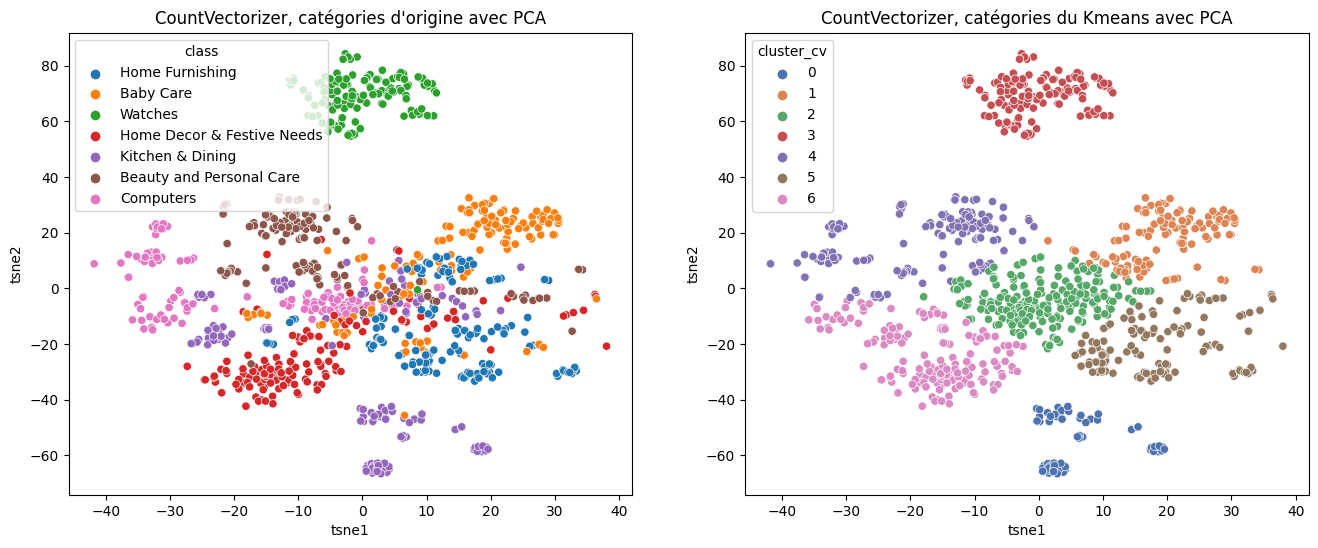

In [20]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne_pca, x="tsne1", y="tsne2", hue="class")
plt.title("CountVectorizer, catégories d'origine avec PCA")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne_pca, x="tsne1", y="tsne2", hue="cluster_cv", palette="deep")
plt.title("CountVectorizer, catégories du Kmeans avec PCA")

Text(0.5, 1.0, 'CountVectorizer, catégories du Kmeans')

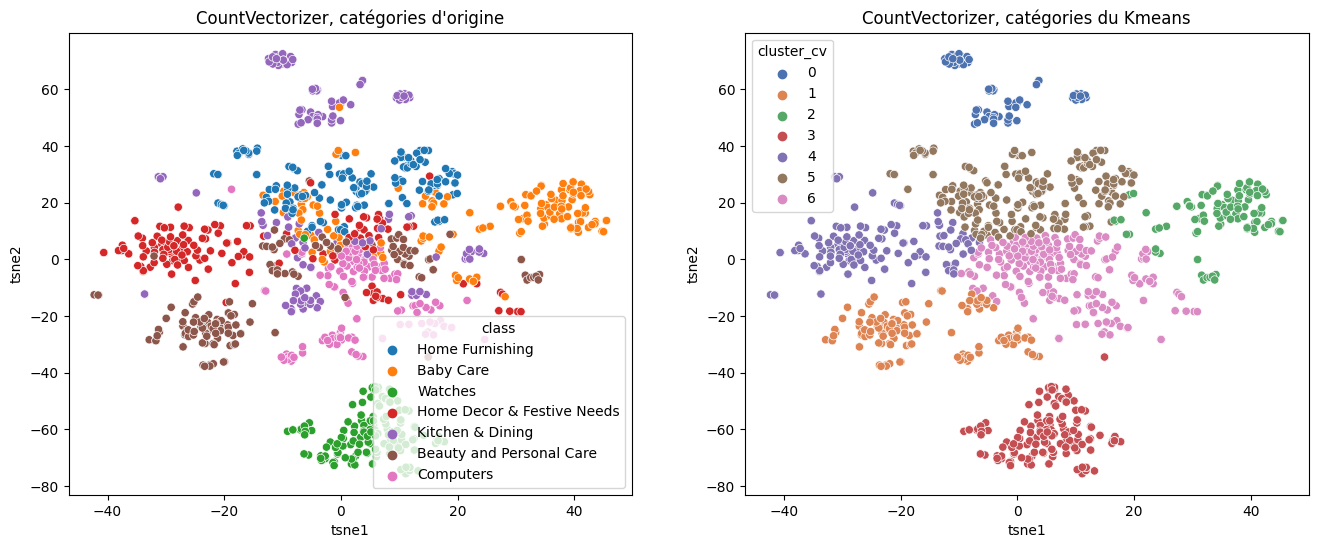

In [21]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne, x="tsne1", y="tsne2", hue="class")
plt.title("CountVectorizer, catégories d'origine")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne, x="tsne1", y="tsne2", hue="cluster_cv", palette="deep")
plt.title("CountVectorizer, catégories du Kmeans")

Text(0.5, 1.0, 'TfidfVectorizer, catégories du Kmeans avec PCA')

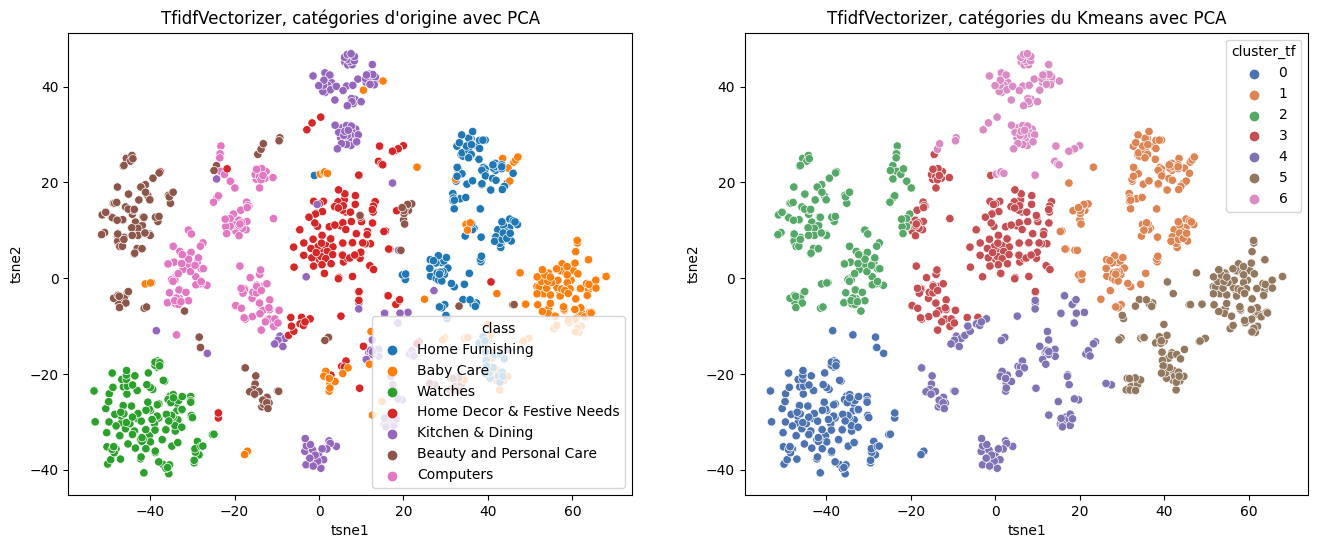

In [22]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne2_pca, x="tsne1", y="tsne2", hue="class")
plt.title("TfidfVectorizer, catégories d'origine avec PCA")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne2_pca, x="tsne1", y="tsne2", hue="cluster_tf", palette="deep")
plt.title("TfidfVectorizer, catégories du Kmeans avec PCA")

Text(0.5, 1.0, 'TfidfVectorizer, catégories du Kmeans')

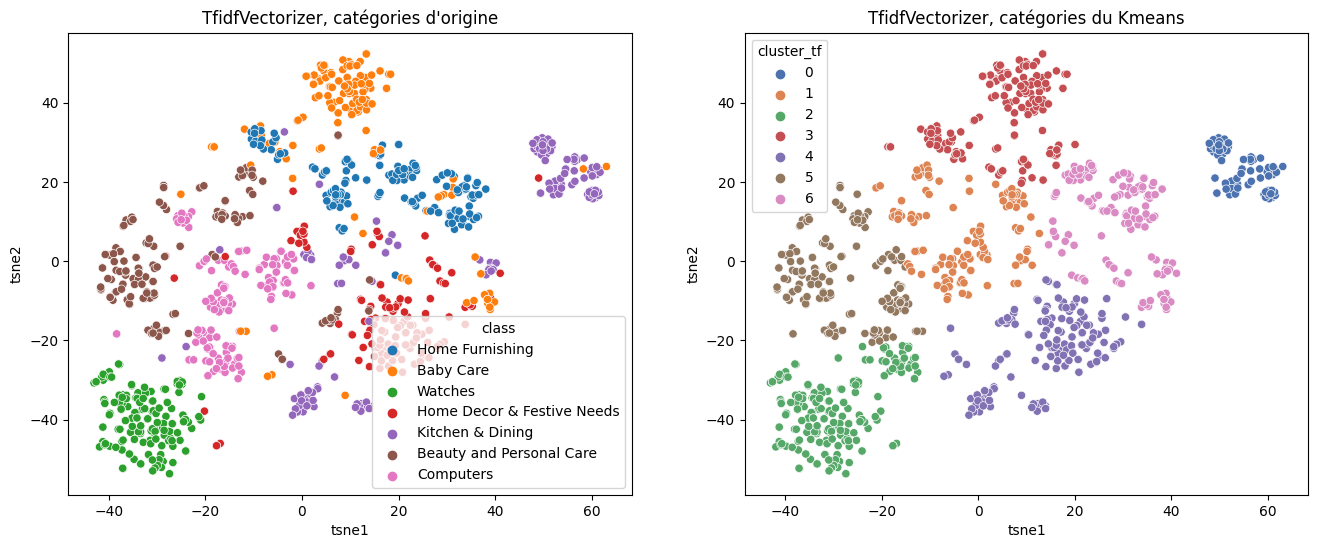

In [23]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne2, x="tsne1", y="tsne2", hue="class")
plt.title("TfidfVectorizer, catégories d'origine")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne2, x="tsne1", y="tsne2", hue="cluster_tf", palette="deep")
plt.title("TfidfVectorizer, catégories du Kmeans")

In [24]:
def freq_stats_corpora():
    cleaned = []
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer3 = WordNetLemmatizer()

    for i in range(df.shape[0]):
        word_tokens = tokenizer.tokenize(str(df.product_name[i].lower())) + tokenizer.tokenize (str(df.description[i].lower()))
        cleaned.append([lemmatizer3.lemmatize(w) for w in word_tokens if not w.isdigit() and w not in string.punctuation and w not in stop_words and w in re.findall(r'[a-z]{3,}', w)])
        
    return cleaned
    
cleaned = freq_stats_corpora()

cleaned

[['elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'key',
  'feature',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'price',
  'curtain',
  'enhances',
  'look',
  'interior',
  'curtain',
  'made',
  'high',
  'quality',
  'polyester',
  'fabric',
  'feature',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'make',
  'room',
  'environment',
  'romantic',
  'loving',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'apparance',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'design',
  'surreal',
  'attention',
  'sure',
  'steal',
  'heart',
  'contemporary',
  'eyelet',
  'valance',
  'curtain',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',
  'morning',
  'welcome',
  'bright',

## Word embedding

In [34]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\dar55\.virtualenvs\Data_Scientist-FqGbSdFt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\dar55\.virtualenvs\Data_Scientist-FqGbSdFt\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [35]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [36]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [37]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = cleaned_tokens_dl_list

loading configuration file config.json from cache at C:\Users\dar55/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\dar55/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [38]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\dar55/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\dar55/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 0s 484ms/step
temps traitement :  59.0


In [39]:
features_bert

array([[ 0.15172543, -0.21575601,  0.8208388 , ..., -0.0409942 ,
        -0.00459807, -0.12038413],
       [ 0.23333967, -0.07541995,  0.49891874, ..., -0.2504056 ,
        -0.14050306,  0.14957906],
       [ 0.22992632, -0.02954565,  0.60496753, ..., -0.2012895 ,
        -0.31217054, -0.01948654],
       ...,
       [ 0.08733042,  0.00828141,  0.45410466, ...,  0.10450612,
        -0.09594198, -0.12280574],
       [ 0.13589306, -0.01894575,  0.39627147, ...,  0.2435524 ,
        -0.16919723, -0.3712628 ],
       [ 0.26490578, -0.15202773,  0.49885103, ...,  0.14063334,
        -0.11174892, -0.19194129]], dtype=float32)

In [40]:
time1 = time.time()

X_embedded4 = TSNE(n_components=2, learning_rate='auto', n_iter=2000,
                   init='random', perplexity=30, random_state=42).fit_transform(features_bert)

df_tsne4 = pd.DataFrame(X_embedded4[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne4["class"] = df_cat['product_category_tree']

cls4 = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls4.fit(X_embedded4)
df_tsne4['cluster'] = cls4.labels_

ARI_bert = np.round(metrics.adjusted_rand_score(df_cat_num['product_category_tree'], cls4.labels_),4)
time2 = np.round(time.time() - time1,0)

print("BERT : ")
print("-----------------")
print("ARI : ", ARI_bert, "time : ", time2)
print("-----------------")

BERT : 
-----------------
ARI :  0.4008 time :  5.0
-----------------


Text(0.5, 1.0, 'BERT, catégories du Kmeans')

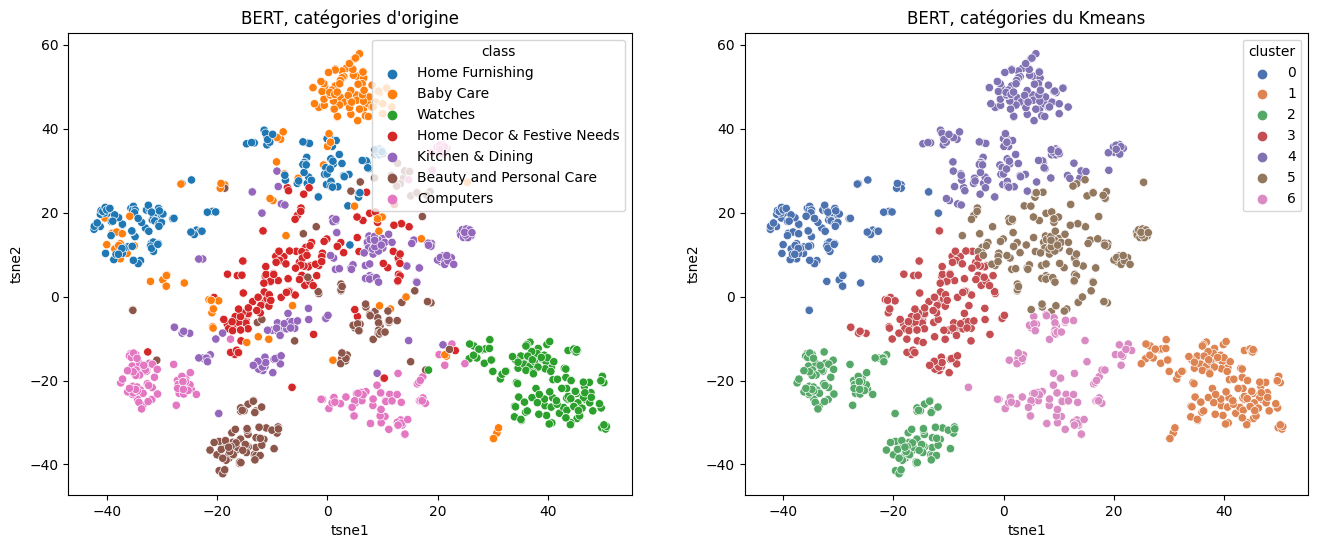

In [41]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
sns.scatterplot(data=df_tsne4, x="tsne1", y="tsne2", hue="class")
plt.title("BERT, catégories d'origine")

ax = fig.add_subplot(122)
sns.scatterplot(data=df_tsne4, x="tsne1", y="tsne2", hue="cluster", palette="deep")
plt.title("BERT, catégories du Kmeans")